<img src="logo_ue.png" width="400"/>


# ANEXO 2
# 3. DESARROLLO DEL PROYECTO - 
## 3.1 Procesamiento y enriquecimiento de los datos de iniciativas y proyectos de inversión
## 3.2 Preparación semántica de los textos

Importar librerias

In [18]:
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from gensim.models import Phrases
import spacy
import es_core_news_sm
from spacy.lang.es.stop_words import STOP_WORDS
from gensim.models.phrases import Phraser
import joblib


Cargar las fuente de información requeridas
* Proyectos definidos por el gobierno nacional, formulados y estructurados bajo la Metodología General Ajustada (MGA).
* Iniciativas PDET constituyen las necesidades comunitarias definidas de forma participativa en los 170 municipios priorizados por el acuerdo de paz.
* División territorial oficial de municipios y departamentos de Colombia

In [5]:
df_proyectos        = pd.read_excel("fuentes_informacion\\ProyectosInversion.xlsx")
df_iniciativas      = pd.read_excel("fuentes_informacion\\IniciativasPDET.xlsx", sheet_name="Iniciativas")
df_municipios       = pd.read_csv("fuentes_informacion\\MunicipiosColombia.csv", delimiter=';')

# 3.1 Procesamiento y enriquecimiento de los datos de iniciativas y proyectos de inversión

### 3.1.1. Carga y normalización de datos

In [6]:
# Estandarizar nombres de columnas para facilitar pasos posteriores
df_iniciativas.columns      = df_iniciativas.columns.str.strip().str.replace(" ", "_").str.lower()
df_proyectos.columns        = df_proyectos.columns.str.strip().str.replace(" ", "_").str.lower()
df_municipios.columns       = df_municipios.columns.str.strip().str.replace(" ", "_").str.lower() 
df_iniciativas.head(2), df_proyectos.head(2), df_municipios.head(2)

# Normalizar el campo 'codigodane' en la base de iniciativas a longitud 5
df_iniciativas['codigodane'] = df_iniciativas['codigodane'].fillna(0).astype(int).astype(str).str.zfill(5)

### 3.1.2. Imputación territorial de iniciativas

In [7]:
# Estandarizar columnas 
df_iniciativas['subregion'] = df_iniciativas['subregión'].astype(str).str.strip().str.upper()
df_municipios['subregion'] = df_municipios['subregion'].astype(str).str.strip().str.upper()
df_municipios['codigodanemunicipio'] = df_municipios['codigodanemunicipio'].astype(str).str.zfill(5)

# Crear diccionario subregión → lista de códigos DANE
mapa_subregion_municipios = (
    df_municipios
    .groupby('subregion')['codigodanemunicipio']
    .apply(list)
    .to_dict()
)

# Imputación
def imputar_codigosdane(row):
    if row['codigodane'] in [None, '00000', '', 'nan']:
        return mapa_subregion_municipios.get(row['subregion'], [])
    else:
        return [row['codigodane']]

df_iniciativas['codigosdane'] = df_iniciativas.apply(imputar_codigosdane, axis=1)

### 3.1.3. Imputación de ubicación geográfica del proyecto a través del código de la entidad

In [8]:
# Normalizar campo 'codigoentidad' a 5 dígitos 
df_proyectos['codigoentidad'] = df_proyectos['codigoentidad'].astype(str).str.strip()
df_proyectos['codigoentidad_normalizado'] = df_proyectos['codigoentidad'].apply(
    lambda x: x.zfill(5) if x.isdigit() and len(x) < 5 else x
)
# Formato en municipios
df_municipios['codigodanemunicipio'] = df_municipios['codigodanemunicipio'].astype(str).str.zfill(5)

# Códigos DANE de municipios PDET y NO PDET
codigos_pdet = set(df_municipios[df_municipios['pdet'] == 1]['codigodanemunicipio'])
codigos_no_pdet = set(df_municipios[df_municipios['pdet'] == 0]['codigodanemunicipio'])

# Eliminar proyectos que cruzan con municipios NO PDET
total_original = len(df_proyectos)
df_proyectos = df_proyectos[~df_proyectos['codigoentidad_normalizado'].isin(codigos_no_pdet)].copy()
print(f"Proyectos eliminados por NO PDET: {total_original - len(df_proyectos)}")

# Imputar 'codigoentidadnormalizado' solo a los que cruzan con municipios PDET
df_proyectos['codigoentidadnormalizado'] = df_proyectos['codigoentidad_normalizado'].apply(
    lambda x: x if x in codigos_pdet else None
)
print(f"Proyectos con código imputado directo (PDET): {df_proyectos['codigoentidadnormalizado'].notnull().sum()}")

Proyectos eliminados por NO PDET: 1926
Proyectos con código imputado directo (PDET): 45960


### 3.1.4. Imputación de ubicación geográfica del proyecto a través del código de la entidad

In [9]:
# Normalizar campos para comparación
df_proyectos['nombreentidad_lower'] = ' ' + df_proyectos['nombreentidad'].astype(str).str.lower().str.strip() + ' '
df_municipios['departamento_lower'] = df_municipios['departamento'].astype(str).str.lower().str.strip()

# Lista de códigos DANE PDET
df_mpios_pdet = df_municipios[df_municipios['pdet'] == 1].copy()
df_mpios_pdet['codigodanemunicipio'] = df_mpios_pdet['codigodanemunicipio'].astype(str).str.zfill(5)

mapa_depto_pdet = (
    df_mpios_pdet
    .groupby('departamento_lower')['codigodanemunicipio']
    .apply(list)
    .to_dict()
)

# Proyectos aún sin imputación
proyectos_sin_cod = df_proyectos[df_proyectos['codigoentidadnormalizado'].isnull()].copy()

# Función para imputar códigos PDET por nombre del departamento
def imputar_por_departamento(nombre_entidad):
    for depto, codigos in mapa_depto_pdet.items():
        if depto in nombre_entidad:
            return codigos
    return None

# Imputar
df_proyectos.loc[proyectos_sin_cod.index, 'codigoentidadnormalizado'] = proyectos_sin_cod[
    'nombreentidad_lower'
].apply(imputar_por_departamento)


# Coincidencias en el campo 'nombre' cruzando con municipios PDET

# Quitar tildes
def quitar_tildes(texto):
    if isinstance(texto, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', texto)
            if unicodedata.category(c) != 'Mn'
        ).lower().strip()
    return texto

# Normalizar el campo nombre del proyecto y municipio
df_proyectos['nombre_sin_tilde'] = df_proyectos['nombre'].apply(quitar_tildes).apply(lambda x: f' {x} ' if isinstance(x, str) else x)

df_mpios_pdet = df_municipios[df_municipios['pdet'] == 1].copy()
df_mpios_pdet['municipio_sin_tilde'] = df_mpios_pdet['municipio'].apply(quitar_tildes).apply(lambda x: f' {x} ')

df_mpios_pdet['codigodanemunicipio'] = df_mpios_pdet['codigodanemunicipio'].astype(str).str.zfill(5)

# Códigos DANE
mapa_municipio_pdet = (
    df_mpios_pdet
    .groupby('municipio_sin_tilde')['codigodanemunicipio']
    .apply(list)
    .to_dict()
)

# Proyectos sin código asignado
proyectos_no_identificados = df_proyectos[df_proyectos['codigoentidadnormalizado'].isnull()].copy()

# Imputación por nombre del proyecto
def buscar_municipio_en_nombre(nombre):
    encontrados = []
    for municipio, codigos in mapa_municipio_pdet.items():
        if municipio in nombre:
            encontrados.extend(codigos)
    return list(set(encontrados)) if encontrados else None


# Imputar
df_proyectos.loc[proyectos_no_identificados.index, 'codigoentidadnormalizado'] = proyectos_no_identificados[
    'nombre_sin_tilde'
].apply(buscar_municipio_en_nombre)
print(f"Proyectos imputados por nombre : {df_proyectos['codigoentidadnormalizado'].apply(lambda x: isinstance(x, list)).sum()}")

Proyectos imputados por nombre : 17603


### 3.1.5. Eliminación de proyectos sin referencia territorial

In [10]:
proyectos_totales = len(df_proyectos)
df_proyectos_final = df_proyectos[df_proyectos['codigoentidadnormalizado'].notnull()].copy()
print(f"Proyectos eliminados por no lograr imputación de código DANE: {proyectos_totales - len(df_proyectos_final)}")
print(f"Total final de proyectos con código imputado: {len(df_proyectos_final)}")


def normalizar_codigos_dane(codigos):
    if isinstance(codigos, list):
        return [str(c).zfill(5) for c in codigos]
    elif isinstance(codigos, str):
        return [codigos.zfill(5)]
    return []

# Aplicar la normalización de formato
df_proyectos_final['codigoentidadnormalizado'] = df_proyectos_final['codigoentidadnormalizado'].apply(normalizar_codigos_dane)
mapa_dane_subregion = df_municipios.set_index('codigodanemunicipio')['subregion'].to_dict()

# Reaplicar el cruce para obtener subregiones
def obtener_subregiones_actualizado(codigos):
    if isinstance(codigos, list):
        return list(set([mapa_dane_subregion.get(codigo) for codigo in codigos if codigo in mapa_dane_subregion]))
    return []

df_proyectos_final['subregionnormalizado'] = df_proyectos_final['codigoentidadnormalizado'].apply(obtener_subregiones_actualizado)

columnas_a_eliminar = ['codigoentidad_normalizado', 'nombreentidad_lower', 'nombre_sin_tilde']
df_proyectos_final.drop(columns=[col for col in columnas_a_eliminar if col in df_proyectos_final.columns], inplace=True)

columnas_a_eliminar = ['subregion']
df_iniciativas.drop(columns=[col for col in columnas_a_eliminar if col in df_iniciativas.columns], inplace=True)

df_proyectos_localizado     = df_proyectos_final.copy()
df_iniciativas_localizado   = df_iniciativas.copy()

Proyectos eliminados por no lograr imputación de código DANE: 3240
Total final de proyectos con código imputado: 63563


### Figura 3.1 Correlación geográfica entre Iniciativas PDET y Proyectos de Inversión

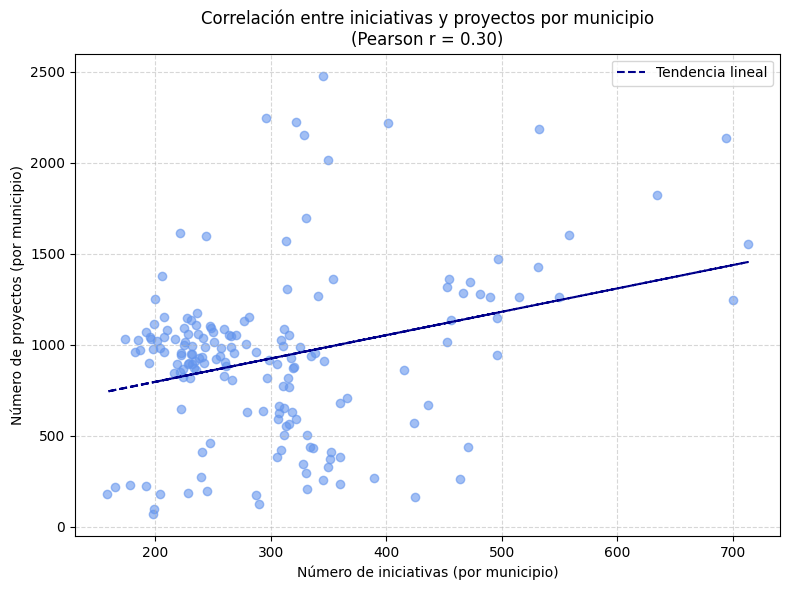

In [11]:
# Asegurar que las columnas con listas estén en el tipo adecuado
df_iniciativas_localizado['codigosdane'] = df_iniciativas_localizado['codigosdane'].apply(
    lambda x: x if isinstance(x, list) else eval(str(x))
)
df_proyectos_localizado['codigoentidadnormalizado'] = df_proyectos_localizado['codigoentidadnormalizado'].apply(
    lambda x: x if isinstance(x, list) else eval(str(x))
)
df_proyectos_localizado['subregionnormalizado'] = df_proyectos_localizado['subregionnormalizado'].apply(
    lambda x: x if isinstance(x, list) else eval(str(x))
)

# ---- Correlación por municipio ----
# Explode para llevar un municipio por fila
df_iniciativas_mpio = df_iniciativas_localizado.explode('codigosdane')
df_proyectos_mpio = df_proyectos.explode('codigoentidadnormalizado')

# Contar por municipio
conteo_iniciativas_mpio = df_iniciativas_mpio['codigosdane'].value_counts().rename_axis('codigodane').reset_index(name='num_iniciativas')
conteo_proyectos_mpio = df_proyectos_mpio['codigoentidadnormalizado'].value_counts().rename_axis('codigodane').reset_index(name='num_proyectos')

# Unir ambos conteos por municipio
df_comparativo_mpio = pd.merge(conteo_iniciativas_mpio, conteo_proyectos_mpio, on='codigodane', how='outer').fillna(0)
df_comparativo_mpio['num_iniciativas'] = df_comparativo_mpio['num_iniciativas'].astype(int)
df_comparativo_mpio['num_proyectos'] = df_comparativo_mpio['num_proyectos'].astype(int)

correlacion_mpio = df_comparativo_mpio[['num_iniciativas', 'num_proyectos']].corr().iloc[0, 1]

# ---- Correlación por subregión ----
# Explode subregiones
df_proyectos_subreg = df_proyectos_localizado.explode('subregionnormalizado')
df_iniciativas_subreg = df_iniciativas_localizado.copy()

# Asignar subregión a iniciativas cruzando con municipios
df_municipios.columns = df_municipios.columns.str.strip().str.replace(" ", "_").str.lower()
df_municipios['codigodanemunicipio'] = df_municipios['codigodanemunicipio'].astype(str).str.zfill(5)
df_municipios['subregion'] = df_municipios['subregion'].astype(str).str.upper().str.strip()
mapa_dane_subregion = df_municipios.set_index('codigodanemunicipio')['subregion'].to_dict()

# Expandir municipios en iniciativas
df_iniciativas_subreg = df_iniciativas_subreg.explode('codigosdane')
df_iniciativas_subreg['codigosdane'] = df_iniciativas_subreg['codigosdane'].astype(str).str.zfill(5)
df_iniciativas_subreg['subregion'] = df_iniciativas_subreg['codigosdane'].map(mapa_dane_subregion)

# Contar por subregión
conteo_iniciativas_subreg = df_iniciativas_subreg['subregion'].value_counts().rename_axis('subregion').reset_index(name='num_iniciativas')
conteo_proyectos_subreg = df_proyectos_subreg['subregionnormalizado'].value_counts().rename_axis('subregion').reset_index(name='num_proyectos')

# Unir
df_comparativo_subreg = pd.merge(conteo_iniciativas_subreg, conteo_proyectos_subreg, on='subregion', how='inner')
correlacion_subreg = df_comparativo_subreg[['num_iniciativas', 'num_proyectos']].corr().iloc[0, 1]

# Resultados
plt.figure(figsize=(8, 6))
x_mpio = df_comparativo_mpio['num_iniciativas']
y_mpio = df_comparativo_mpio['num_proyectos']
plt.scatter(x_mpio, y_mpio, alpha=0.6, color='cornflowerblue')

# Línea de tendencia
m_mpio, b_mpio = np.polyfit(x_mpio, y_mpio, 1)
plt.plot(x_mpio, m_mpio * x_mpio + b_mpio, color='darkblue', linestyle='--', label='Tendencia lineal')

plt.title(f'Correlación entre iniciativas y proyectos por municipio\n(Pearson r = {correlacion_mpio:.2f})')
plt.xlabel('Número de iniciativas (por municipio)')
plt.ylabel('Número de proyectos (por municipio)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# PASO 2. Preparación semántica de los textos

In [12]:
tqdm.pandas()
nlp = es_core_news_sm.load()

def quitar_tildes(texto):
    texto = unicodedata.normalize('NFKD', texto)
    return ''.join([c for c in texto if not unicodedata.combining(c)])

def limpiar_y_lematizar(texto):
    if not isinstance(texto, str):
        return ''
    texto = texto.lower()
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc if token.is_alpha and token.text not in STOP_WORDS]
    return ' '.join(lemas)

# Campos combinados
print("📦 Preparando textos base...")
df_iniciativas['texto_iniciativa'] = (
    df_iniciativas['título_iniciativa'].astype(str) + ' ' +
    df_iniciativas['descripción_iniciativa'].astype(str)
)

df_proyectos['texto_proyecto'] = (
    df_proyectos['nombre'].astype(str) + ' ' +
    df_proyectos['descripcion'].astype(str) + ' ' +
    df_proyectos['objetivogeneral'].astype(str)
)

# Lematización 
print("🔄 Lematizando iniciativas...")
df_iniciativas['texto_lematizado'] = df_iniciativas['texto_iniciativa'].progress_apply(limpiar_y_lematizar)

print("🔄 Lematizando proyectos...")
df_proyectos['texto_lematizado'] = df_proyectos['texto_proyecto'].progress_apply(limpiar_y_lematizar)

# Bigramas
print("🔧 Entrenando modelo de bigramas...")
corpus_iniciativas = df_iniciativas['texto_lematizado'].apply(lambda x: x.split()).tolist()
corpus_proyectos = df_proyectos['texto_lematizado'].apply(lambda x: x.split()).tolist()

modelo_bigramas = Phrases(corpus_iniciativas + corpus_proyectos, min_count=2, threshold=5)
phraser_bigramas = Phraser(modelo_bigramas)

print("📊 Aplicando bigramas a iniciativas...")
df_iniciativas['texto_bigramado'] = [' '.join(phraser_bigramas[d]) for d in tqdm(corpus_iniciativas)]

print("📊 Aplicando bigramas a proyectos...")
df_proyectos['texto_bigramado'] = [' '.join(phraser_bigramas[d]) for d in tqdm(corpus_proyectos)]

# ===== Quitar tildes 
print("🧹 Eliminando tildes y almacenando resultados...")
df_iniciativas['texto_preprocesado'] = df_iniciativas['texto_bigramado'].progress_apply(quitar_tildes)
df_proyectos['texto_preprocesado'] = df_proyectos['texto_bigramado'].progress_apply(quitar_tildes)


print("Guardando modelos...")
# Guardar modelo de bigramas
joblib.dump(phraser_bigramas, "fuentes_informacion\\bigram_model.pkl")
print("✅ bigram_model.pkl guardado correctamente.")

# Guardar lista de stopwords
joblib.dump(STOP_WORDS, "fuentes_informacion\\stopwords.pkl") #Se guarda el mismo Stopwords por si a futuro se cambia, con esto garantizamos que sea el mismo
print("✅ stopwords.pkl guardado correctamente.")


📦 Preparando textos base...
🔄 Lematizando iniciativas...


100%|██████████| 33007/33007 [07:02<00:00, 78.06it/s] 


🔄 Lematizando proyectos...


100%|██████████| 66803/66803 [21:47<00:00, 51.10it/s]


🔧 Entrenando modelo de bigramas...
📊 Aplicando bigramas a iniciativas...


100%|██████████| 33007/33007 [00:01<00:00, 23373.91it/s]


📊 Aplicando bigramas a proyectos...


100%|██████████| 66803/66803 [00:05<00:00, 11523.92it/s]


🧹 Eliminando tildes y almacenando resultados...


100%|██████████| 66803/66803 [00:07<00:00, 9065.14it/s]


Guardando modelos...
✅ bigram_model.pkl guardado correctamente.
✅ stopwords.pkl guardado correctamente.


### Tabla 3.2. Muestra de texto original y texto procesado en iniciativas

In [13]:
pd.set_option('display.max_colwidth', None)
tabla_iniciativas = df_iniciativas[['título_iniciativa', 'descripción_iniciativa', 'texto_preprocesado']].head(1)
display(tabla_iniciativas)


,título_iniciativa,descripción_iniciativa,texto_preprocesado
0,"Adecuar y optimizar la infraestructura existente del acueducto veredal en la zona rural, de los caseríos y centros poblados, para el abastecimiento permanente del agua, en cantidad, óptima y de calidad para el consumo humano y colectivo y demás necesidades básicas, en el municipio de San Calixto, Norte de Santander.","Se requiere la adecuación y la optimización de la infraestructura existente del acueducto, en un plazo no mayor a 2 años, teniendo en cuenta que la población requiere el abastecimiento permanente del agua, en cantidad, con calidad y óptima para el consumo humano y colectivo y demás necesidades básicas, para el núcleo Arboledas: veredas el Silencio, la Torcoroma, Piletas y Balsamina; núcleo Banderas: veredas Banderas y la Laguna; núcleo Cabecera: veredas la Marina, Casas Viejas, Cucurina y la Quina; núcleo San José de la Sabana: veredas Yerbabuena, Vista Hermosa, Fátima, San José de la Sabana, Mesallana, Lagunetas, Chimenecas, Algarrobos, municipio de San Calixto, Norte de Santander; teniendo en cuenta el mejoramiento y la optimización de las obras de la bocatoma de captación del agua, desarenador, obras de aducción o conducción, planta de tratamiento, tanques de almacenamiento y sistemas de distribución.",adecuar optimizar infraestructura existente acueducto_veredal zona_rural caserio centro_poblado abastecimiento permanente agua cantidad optimo_calidad consumo_humano colectivo necesidad_basico municipio san_calixto norte_santander requerir adecuacion optimizacion infraestructura existente acueducto plazo_ano tener poblacion requerir abastecimiento permanente agua cantidad_calidad optimo consumo_humano colectivo necesidad_basico nucleo arboleda vereda_silencio torcoroma pileta balsamina nucleo bandera vereda bandera laguna nucleo_cabecerar vereda marina casa_viejo cucurin quina nucleo san_jose sabana vereda yerbabuen vista_hermoso fatimo san_jose sabana mesallan lagunetas chimeneca algarrobo municipio san_calixto norte_santander tener mejoramiento optimizacion obra bocatoma_captacion agua desarenador obra aduccion_conduccion planta_tratamiento tanque_almacenamiento sistema distribucion


### Figura 3.2. Distribución de la cantidad de palabras (tokens) antes y después del preprocesamiento en los textos de iniciativas PDET y proyectos de inversión pública

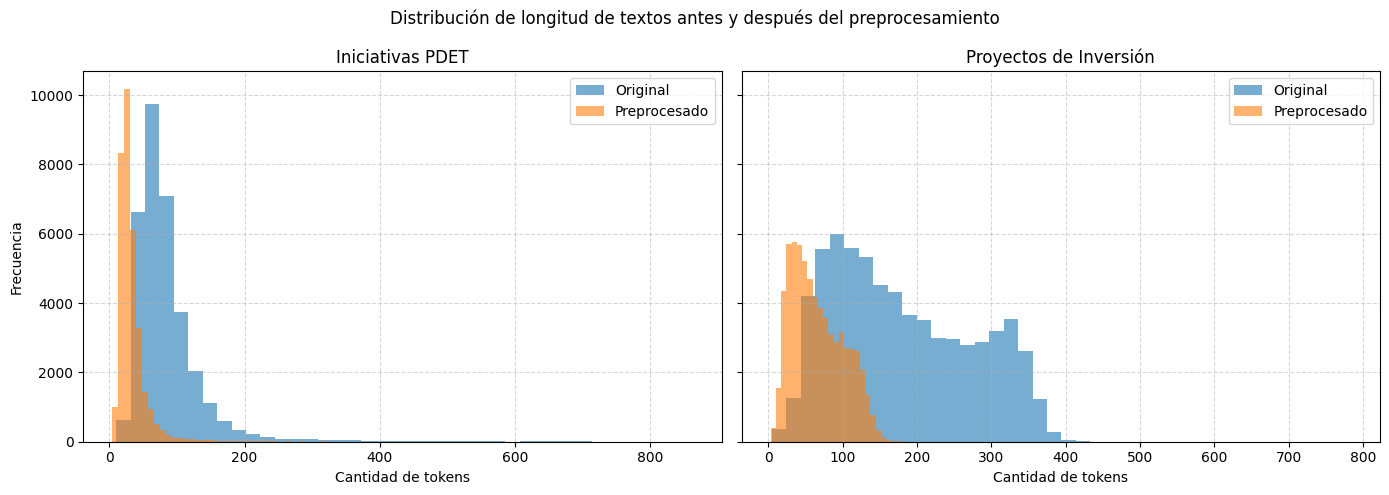

In [14]:
# Calcular longitud de textos (número de palabras) antes y después para iniciativas
df_iniciativas['longitud_original'] = df_iniciativas['texto_iniciativa'].apply(lambda x: len(str(x).split()))
df_iniciativas['longitud_preprocesado'] = df_iniciativas['texto_preprocesado'].apply(lambda x: len(str(x).split()))

# Calcular longitud de textos (número de palabras) antes y después para proyectos
df_proyectos['longitud_original'] = df_proyectos['texto_proyecto'].apply(lambda x: len(str(x).split()))
df_proyectos['longitud_preprocesado'] = df_proyectos['texto_preprocesado'].apply(lambda x: len(str(x).split()))

# Crear gráfico comparativo
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Subgráfico 1: Iniciativas
axs[0].hist(df_iniciativas['longitud_original'], bins=40, alpha=0.6, label='Original')
axs[0].hist(df_iniciativas['longitud_preprocesado'], bins=40, alpha=0.6, label='Preprocesado')
axs[0].set_title('Iniciativas PDET')
axs[0].set_xlabel('Cantidad de tokens')
axs[0].set_ylabel('Frecuencia')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Subgráfico 2: Proyectos
axs[1].hist(df_proyectos['longitud_original'], bins=40, alpha=0.6, label='Original')
axs[1].hist(df_proyectos['longitud_preprocesado'], bins=40, alpha=0.6, label='Preprocesado')
axs[1].set_title('Proyectos de Inversión')
axs[1].set_xlabel('Cantidad de tokens')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Distribución de longitud de textos antes y después del preprocesamiento')
plt.tight_layout()
plt.show()

In [15]:
# ===== 8. Exportar a Excel =====
print("💾 Guardando archivos Excel...")
df_iniciativas.to_excel("fuentes_informacion\IniciativasPDET_preprocesadas.xlsx", index=False)
df_proyectos.to_excel("fuentes_informacion\ProyectosInversion_preprocesados.xlsx", index=False)

print("✅ ¡Proceso completado! Resultados guardados.")

💾 Guardando archivos Excel...
✅ ¡Proceso completado! Resultados guardados.
